In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors 
import tqdm
from scipy.interpolate import griddata, SmoothSphereBivariateSpline, Rbf
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D


sys.path.append('../my_funcs/')
from pipeline_main import pipeline

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

Initialising patch data


100%|██████████| 4165/4165 [00:03<00:00, 1269.49it/s]


21211.7281094472
Converged mean angular momentum vector after 0 iteration(s)
Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:00<00:00, 9230.07it/s] 
/lustre/hpc/astro/kxm508/codes/dispatch2/experiments/ISM/python/streamers/../my_funcs/pipeline_main.py:154: RuntimeWarning: invalid value encountered in sqrt
  σ_φ = np.sqrt(self.vφ2 - self.vφ**2)


Disk size: 41.3 au


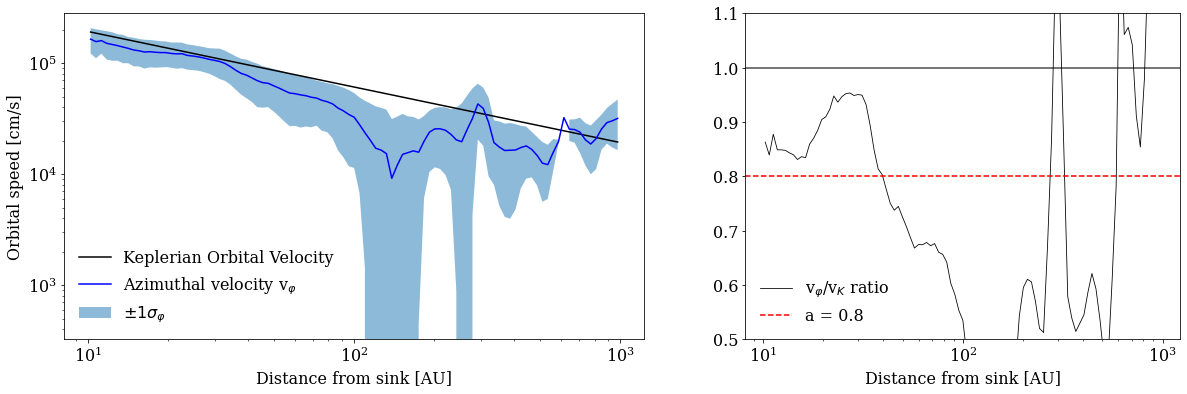

In [2]:
data = pipeline(snap = 710, run = 'my_core_13restart')
print(data.time)
data.recalc_L(verbose = 1); 
data.calc_disksize()

In [3]:
shell_r = 50
Δ_r = 1
shell_r /= data.au_length; Δ_r /= data.au_length

# VERY IMPORTANT NOTE: After the transformation the first axis is the height
patch_values = []
patch_cartcoor = []
longtitude = []
latitude = []
zoverR = []
for p in tqdm.tqdm(data.sn.patches):       
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    R = np.linalg.norm(p.rel_xyz, axis = 0)
    idx = np.asarray(np.nonzero((R < shell_r + Δ_r) & (R > shell_r - Δ_r)))
    for lp in leafs: 
        extent = np.vstack((lp.position - 0.5 * lp.size, p.position + 0.5 * p.size)).T
        covered_idx = np.asarray(np.nonzero((p.xyz[0] > extent[0,0]) & ((p.xyz[0] < extent[0,1]))
                                 & (p.xyz[1] > extent[1,0]) & ((p.xyz[1] < extent[1,1]))
                                 & (p.xyz[2] > extent[2,0]) & ((p.xyz[2] < extent[2,1]))))

        to_remove_from_idx = np.all(idx.T[:, None, :] == covered_idx.T, axis = -1).any(axis = 1)
        idx = np.copy(idx.T[~to_remove_from_idx].T)
        if np.sum(idx) == 0:
            break
    if np.sum(idx) == 0:
            continue    

    new_xyz = p.rel_xyz[:, idx[0], idx[1], idx[2]].T
    new_r = p.cyl_r[:, idx[0], idx[1], idx[2]].T
    new_R = np.linalg.norm(new_xyz, axis = 1)
    new_z = p.cyl_z[idx[0], idx[1], idx[2]].T
    new_coor = p.cyl_r[:, idx[0], idx[1], idx[2]].T
    new_value = (p.var('d') * np.sum(p.vrel * (p.rel_xyz)/np.linalg.norm(p.rel_xyz, axis = 0), axis = 0))[idx[0], idx[1], idx[2]].T # USE V_r * rho

    longtitude.extend(np.arctan2(new_r[:,1],  new_r[:,0]).tolist())
    latitude.extend((np.arcsin(new_z / new_R)).tolist())    
    patch_values.extend(new_value.tolist())
    patch_cartcoor.extend(new_xyz.tolist())
    
patch_cartcoor = np.asarray(patch_cartcoor) * data.au_length
longtitude = np.asarray(longtitude)
latitude = np.asarray(latitude)
patch_values = np.asarray(patch_values)
sphere_coor = np.hstack((longtitude[:,None], latitude[:, None]))

values = patch_values * data.msun_mass / (data.au_length**2 * data.sn.cgs.yr)

values.min(), values.max()

100%|██████████| 4165/4165 [00:00<00:00, 4564.18it/s]


(-2.5937733064834094e-09, 1.2610039347066875e-09)

In [4]:
'''%matplotlib widget
fig = plt.figure(figsize = (12,12))
ax = Axes3D(fig)

ax.scatter(patch_cartcoor[:,0], patch_cartcoor[:,1], patch_cartcoor[:,2])'''

'%matplotlib widget\nfig = plt.figure(figsize = (12,12))\nax = Axes3D(fig)\n\nax.scatter(patch_cartcoor[:,0], patch_cartcoor[:,1], patch_cartcoor[:,2])'

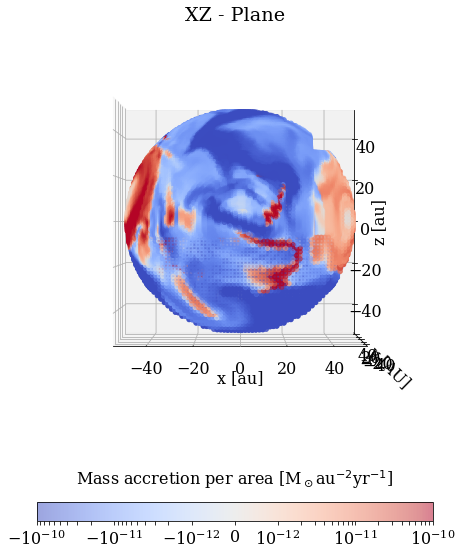

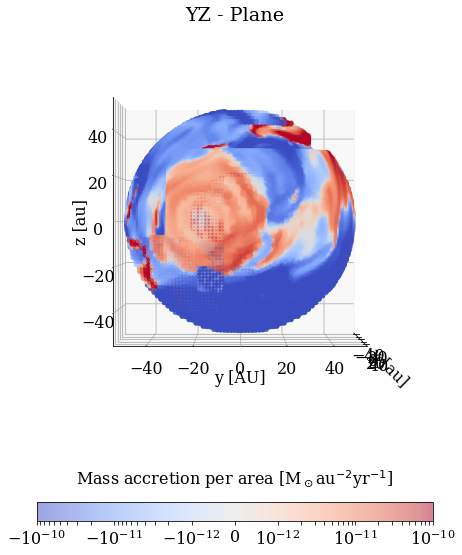

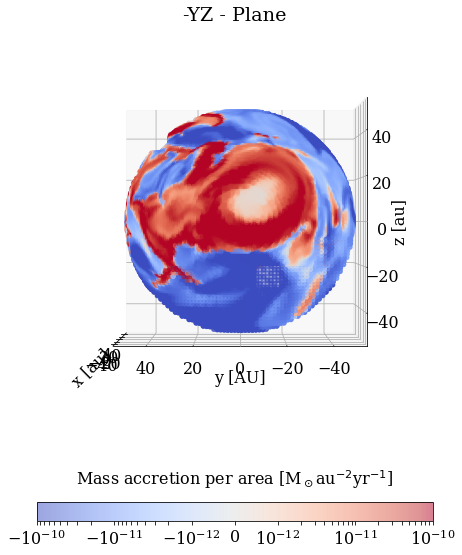

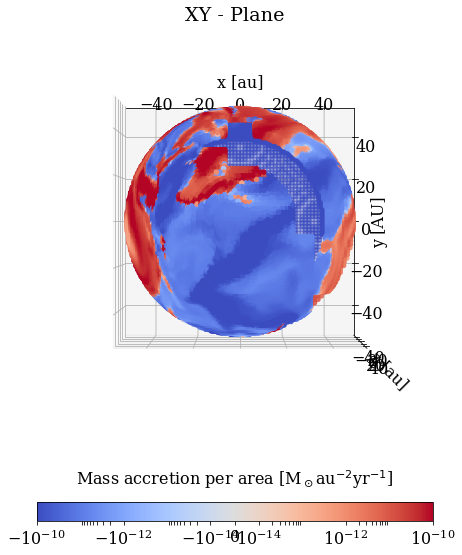

In [5]:
plane = ['XZ', 'YZ', '-YZ']
azim = [-90, 0, 180]
lim = shell_r * data.au_length + 2
xs, ys, zs = patch_cartcoor.T
range = 1e-10
for p, a in zip(plane, azim):
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(projection='3d')

    im = ax.scatter(xs, ys, zs, ',', c = values, cmap='coolwarm', norm=colors.SymLogNorm(linthresh=1e-12, linscale = 0.5, vmin = -range, vmax = range), alpha = 0.5)
    cbar = fig.colorbar(im, orientation='horizontal', fraction = 0.04)
    ax.quiver(0,0,0, data.L[0], data.L[1], data.L[2], length=30, color = 'black', arrow_length_ratio=0.1 )
    ax.quiver(0,0,0, -data.L[0], -data.L[1], -data.L[2], length=30, color = 'black', arrow_length_ratio=0.00 )
    cbar.set_label('Mass accretion per area [M$_\odot$au$^{-2}$yr$^{-1}$]', labelpad = -80, y = 2, rotation = 0, fontsize = 16)
    #ax.set_aspect('equal')
    ax.set(ylabel = 'y [AU]', xlabel = 'x [au]', zlabel = 'z [au]', xlim = (-lim, lim), ylim = (-lim, lim), zlim = (-lim, lim), title = p+' - Plane')
    ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs))) 
    ax.view_init(elev=0, azim=a)
    fig.tight_layout()

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(projection='3d')

im = ax.scatter(xs, ys, zs, ',', c = values, cmap='coolwarm', norm=colors.SymLogNorm(linthresh=1e-14, linscale = 0.5, vmin = -range, vmax = range))
cbar = fig.colorbar(im, orientation='horizontal', fraction = 0.04)
cbar.set_label('Mass accretion per area [M$_\odot$au$^{-2}$yr$^{-1}$]', labelpad = -80, y = 2, rotation = 0, fontsize = 16)

ax.set(ylabel = 'y [AU]', xlabel = 'x [au]', zlabel = 'z [au]', xlim = (-lim, lim), ylim = (-lim, lim), zlim = (-lim, lim), title = 'XY - Plane')
ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs))) 
ax.view_init(elev=90, azim=-90)
ax.quiver(0,0,0, data.L[0], data.L[1], data.L[2], length=30, color = 'black', arrow_length_ratio=0.1 )
ax.quiver(0,0,0, -data.L[0], -data.L[1], -data.L[2], length=30, color = 'black', arrow_length_ratio=0.00 )
fig.tight_layout()

In [6]:
data.calc_trans_xyz()

Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:00<00:00, 14178.34it/s]


In [7]:
shell_r = 50
Δ_r = 1
shell_r /= data.au_length; Δ_r /= data.au_length

# VERY IMPORTANT NOTE: After the transformation the first axis is the height
patch_values = []
patch_cartcoor = []
longtitude = []
latitude = []
zoverR = []
for p in tqdm.tqdm(data.sn.patches):       
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    R = np.linalg.norm(p.trans_xyz, axis = 0)
    idx = np.asarray(np.nonzero((R < shell_r + Δ_r) & (R > shell_r - Δ_r)))
    for lp in leafs: 
        extent = np.vstack((lp.position - 0.5 * lp.size, p.position + 0.5 * p.size)).T
        covered_idx = np.asarray(np.nonzero((p.xyz[0] > extent[0,0]) & ((p.xyz[0] < extent[0,1]))
                                 & (p.xyz[1] > extent[1,0]) & ((p.xyz[1] < extent[1,1]))
                                 & (p.xyz[2] > extent[2,0]) & ((p.xyz[2] < extent[2,1]))))

        to_remove_from_idx = np.all(idx.T[:, None, :] == covered_idx.T, axis = -1).any(axis = 1)
        idx = np.copy(idx.T[~to_remove_from_idx].T)
        if np.sum(idx) == 0:
            break
    if np.sum(idx) == 0:
            continue    

    new_xyz = p.trans_xyz[:, idx[0], idx[1], idx[2]].T
    new_r = p.cyl_r[:, idx[0], idx[1], idx[2]].T
    new_R = np.linalg.norm(new_xyz, axis = 1)
    new_z = p.cyl_z[idx[0], idx[1], idx[2]].T
    new_coor = p.cyl_r[:, idx[0], idx[1], idx[2]].T
    new_value = (p.var('d') * np.sum(p.vrel * (p.rel_xyz)/np.linalg.norm(p.rel_xyz, axis = 0), axis = 0))[idx[0], idx[1], idx[2]].T

    longtitude.extend(np.arctan2(new_r[:,1],  new_r[:,0]).tolist())
    latitude.extend((np.arcsin(new_z / new_R)).tolist())    
    patch_values.extend(new_value.tolist())
    patch_cartcoor.extend(new_xyz.tolist())
    
patch_cartcoor = np.asarray(patch_cartcoor) * data.au_length
longtitude = np.asarray(longtitude)
latitude = np.asarray(latitude)
patch_values = np.asarray(patch_values)
sphere_coor = np.hstack((longtitude[:,None], latitude[:, None]))

values = patch_values * data.msun_mass / (data.au_length**2 * data.sn.cgs.yr)

  0%|          | 0/4165 [00:00<?, ?it/s]

100%|██████████| 4165/4165 [00:00<00:00, 4439.13it/s]


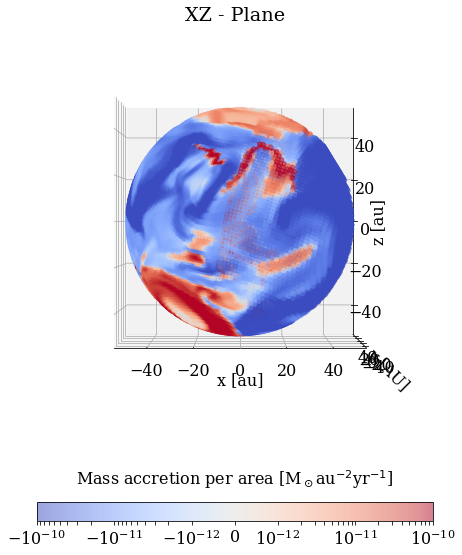

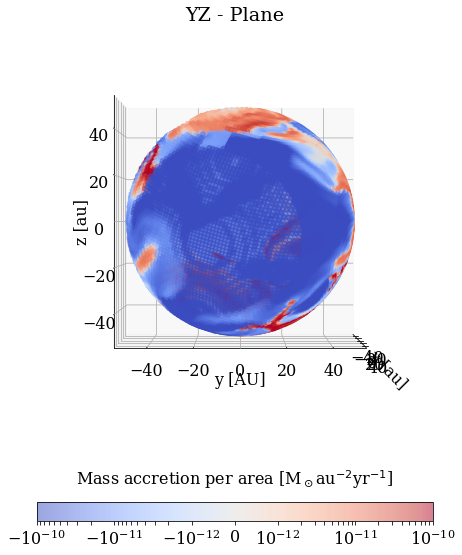

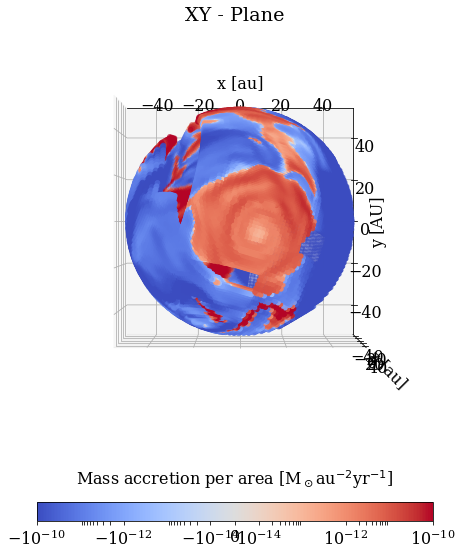

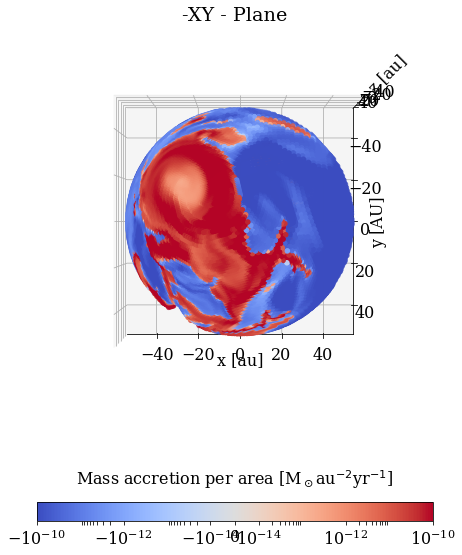

In [11]:
plane = ['XZ', 'YZ']
azim = [-90, 0]
lim = shell_r * data.au_length + 2
xs, ys, zs = patch_cartcoor.T
range = 1e-10
for p, a in zip(plane, azim):
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(projection='3d')

    im = ax.scatter(xs, ys, zs, ',', c = values, cmap='coolwarm', norm=colors.SymLogNorm(linthresh=1e-12, linscale = 0.5, vmin = -range, vmax = range), alpha = 0.5)
    cbar = fig.colorbar(im, orientation='horizontal', fraction = 0.04)
    ax.quiver(0,0,0, 0, 0, 1, length=30, color = 'black', arrow_length_ratio=0.1 )
    ax.quiver(0,0,0, 0, 0, -1, length=30, color = 'black', arrow_length_ratio=0.00 )
    cbar.set_label('Mass accretion per area [M$_\odot$au$^{-2}$yr$^{-1}$]', labelpad = -80, y = 2, rotation = 0, fontsize = 16)
    #ax.set_aspect('equal')
    ax.set(ylabel = 'y [AU]', xlabel = 'x [au]', zlabel = 'z [au]', xlim = (-lim, lim), ylim = (-lim, lim), zlim = (-lim, lim), title = p+' - Plane')
    ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs))) 
    ax.view_init(elev=0, azim=a)
    fig.tight_layout()

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(projection='3d')

im = ax.scatter(xs, ys, zs, ',', c = values, cmap='coolwarm', norm=colors.SymLogNorm(linthresh=1e-14, linscale = 0.5, vmin = -range, vmax = range))
cbar = fig.colorbar(im, orientation='horizontal', fraction = 0.04)
cbar.set_label('Mass accretion per area [M$_\odot$au$^{-2}$yr$^{-1}$]', labelpad = -80, y = 2, rotation = 0, fontsize = 16)

ax.set(ylabel = 'y [AU]', xlabel = 'x [au]', zlabel = 'z [au]', xlim = (-lim, lim), ylim = (-lim, lim), zlim = (-lim, lim), title = 'XY - Plane')
ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs))) 
ax.view_init(elev=90, azim=-90)
ax.quiver(0,0,0, 0, 0, 1, length=30, color = 'black', arrow_length_ratio=0.1 )
ax.quiver(0,0,0, 0, 0, -1, length=30, color = 'black', arrow_length_ratio=0.00 )
fig.tight_layout()

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(projection='3d')

im = ax.scatter(xs, ys, zs, ',', c = values, cmap='coolwarm', norm=colors.SymLogNorm(linthresh=1e-14, linscale = 0.5, vmin = -range, vmax = range))
cbar = fig.colorbar(im, orientation='horizontal', fraction = 0.04)
cbar.set_label('Mass accretion per area [M$_\odot$au$^{-2}$yr$^{-1}$]', labelpad = -80, y = 2, rotation = 0, fontsize = 16)

ax.set(ylabel = 'y [AU]', xlabel = 'x [au]', zlabel = 'z [au]', xlim = (-lim, lim), ylim = (-lim, lim), zlim = (-lim, lim), title = '-XY - Plane')
ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs))) 
ax.view_init(elev=-90, azim=-90)
ax.quiver(0,0,0, 0, 0, 1, length=40, color = 'black', arrow_length_ratio=0.1 )
ax.quiver(0,0,0, 0, 0, -1, length=30, color = 'black', arrow_length_ratio=0.00 )
fig.tight_layout()

In [9]:
t = np.ones((3,3))
t[2] = 0.5
np.dot(t, np.ones(3))

array([3. , 3. , 1.5])

In [10]:
np.sum(t, axis = 1)

array([3. , 3. , 1.5])